# Normalizing Depth to Euphotic Zone

Josie Donnelly

*Last updated 11.04.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random

import matplotlib.pyplot as plt
%matplotlib inline


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093


In [3]:
df_orig.columns


Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'TEMP', 'CHLA']]
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

# consider only the observations for which the target CHLA is available
df = df[~df['CHLA'].isna()].reset_index(drop=True)
df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [5]:
floats = np.unique(df['float'])
print(f'Number of unique floats: {len(floats)}')


Number of unique floats: 565


## Discribe estimation process and visualize CHLA dropoff for a few examples


Here is the procedure for estimating the bottom of the euphotic zone (refered to as the "euphotic floor"):

* Consider all CHLA values for each cycle of each float, ordered by raw depth (ascending)

* Starting at the depth at which the peak CHLA value occurs for that cycle, step through the CHLA values as depth decreases, considering one value at a time

* If the CHLA value at the depth considered is "close enough" to some near-zero error (chosen to be the maximum of these two values: the minimum CHLA value for the cycle, or 1% of the peak CHLA value for the cycle), consider this value to be smallest tolerable CHLA value; therefore the depth is consideration is taken as the euphotic floor.

* Disregard all depths below the determined euphotic floor.

* Divide all depths in the cycle by the euphotic floor estimate to obtain the normalized depth.

Note that there are a small handful of cycles that do not yield an estimate for the euphotic floor due to peaks at unreasonable depths, CHLA values never dropping near enough to zero, etc. These examples will have to be handled separately.

In [139]:
# function to plot a path of a float cycle on a map, colored by raw depth (PRES) by default
def plot_on_map(tmp_df, color_by='PRES', cmap='plasma_r', figsize=(10,4), title=None):
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    land.plot(color='lightgray', figsize=figsize)
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], c=tmp_df[color_by], cmap=cmap, s=1, alpha=0.7)
    cbar = plt.colorbar(label=color_by)
    cbar.ax.invert_yaxis()
    if title is None:
        plt.title(f'Cycle {tmp_df.loc[0,"cycleNumber"]} of Float {tmp_df.loc[0,"float"]}')
    else:
        plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    plt.show()
    

In [47]:
def plot_chla_dropoff(cycle_df, euphotic_floor_guess, figsize=(16,6)):
    plt.plot(cycle_df['PRES'], cycle_df['CHLA'])
    if euphotic_floor_guess is not None:
        plt.axvline(x=euphotic_floor_guess, color='r')
    plt.title(f'CHLA Dropoff for Cycle {cycle_df.loc[0,"cycleNumber"]} of Float {cycle_df.loc[0,"float"]}')
    plt.xlabel('raw depth')
    plt.ylabel('CHLA')
    
    plt.show()
    

Float 5904688, cycle 4
Number of observations in cycle: 536
Peak: 0.7956
Min: 0.0000
Euphotic floor estimate: 156m


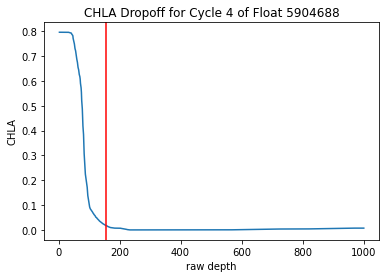

In [125]:
# plot path on map and CHLA dropoff for a random float-cycle
err = 0.01
euphotic_floor_guess = None
f = random.choice(floats)
# intetesting choices for float-cycle psirs: float 6902735, cycle 352; float 6901180, cycle 238
float_df = df[df['float'] == f]
cycles = np.unique(float_df['cycleNumber'])
c = random.choice(cycles)
cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
max_chla = max(cycle_df['CHLA'])
min_chla = max(0, min(cycle_df['CHLA']))
print(f'Float {f}, cycle {c}')
print(f'Number of observations in cycle: {cycle_df.shape[0]}')
print(f'Peak: {max_chla:.4f}')
print(f'Min: {min_chla:.4f}')

# obtain estimate for bottom of euphotic zone depth
chla_thresh = max(min_chla, 0.01*max_chla)

# consider only values after the peak
for i in range(list(cycle_df['CHLA']).index(max_chla), cycle_df.shape[0]):
    if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
        euphotic_floor_guess = cycle_df.loc[i,'PRES']
        break

if euphotic_floor_guess is None:
    unit = ''
else:
    unit='m'
print(f'Euphotic floor estimate: {euphotic_floor_guess}{unit}')

# visualize the guess
plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
# plot_on_map(cycle_df)


## Obtain euphotic floor estimates

In [109]:
# obtain bottom of euphotic zone estimates for all cycles
estimate_not_found = []
err = 0.01

# intialize dataframe to keep results
normalized_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
normalized_df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA


In [110]:
for num, f in enumerate(floats):
    float_df = df[df['float'] == f]
    cycles = np.unique(float_df['cycleNumber'])
    print(f'{num:<3} float {f:<9} ({len(cycles)} cycles)')
    
    float_results_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
    
    for c in cycles:
        euphotic_floor_guess = None
    
        cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
        max_chla = max(cycle_df['CHLA'])
        min_chla = max(0, min(cycle_df['CHLA']))

        # obtain estimate for bottom of euphotic zone depth
        chla_thresh = max(min_chla, 0.01*max_chla)

        # consider only values after the peak
        for i in range(list(cycle_df['CHLA']).index(max_chla), cycle_df.shape[0]):
            if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
                euphotic_floor_guess = cycle_df.loc[i,'PRES']
                break

        if euphotic_floor_guess is None:
            estimate_not_found.append((f,c))
            print(f'\tRetry: float {f}, cycle {c}')
            
#         plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)

        cycle_df = cycle_df[cycle_df['PRES'] <= euphotic_floor_guess]
        cycle_df.insert(loc=list(cycle_df.columns).index('PRES')+1, column='normalized_depth', value=[d/euphotic_floor_guess for d in cycle_df['PRES']])

        float_results_df = pd.concat([float_results_df, cycle_df])
        
    normalized_df = pd.concat([normalized_df, float_results_df])
        

0   float 1902303   (72 cycles)
1   float 1902304   (91 cycles)
2   float 1902380   (12 cycles)
3   float 1902381   (13 cycles)
4   float 1902382   (13 cycles)
5   float 1902383   (12 cycles)
6   float 1902384   (12 cycles)
7   float 1902385   (12 cycles)
8   float 2902086   (213 cycles)
9   float 2902088   (201 cycles)
10  float 2902090   (6 cycles)
11  float 2902091   (12 cycles)
12  float 2902092   (58 cycles)
13  float 2902093   (188 cycles)
14  float 2902113   (2 cycles)
15  float 2902114   (243 cycles)
16  float 2902115   (220 cycles)
17  float 2902118   (115 cycles)
18  float 2902120   (245 cycles)
19  float 2902123   (179 cycles)
	Retry: float 2902123, cycle 6
20  float 2902124   (110 cycles)
21  float 2902129   (20 cycles)
22  float 2902130   (169 cycles)
23  float 2902131   (87 cycles)
24  float 2902156   (106 cycles)
25  float 2902158   (96 cycles)
26  float 2902161   (1 cycles)
27  float 2902209   (18 cycles)
28  float 2902210   (13 cycles)
29  float 2902211   (18 cycles)
3

251 float 5906040   (303 cycles)
252 float 5906043   (103 cycles)
253 float 5906044   (86 cycles)
254 float 5906204   (84 cycles)
255 float 5906205   (83 cycles)
256 float 5906206   (83 cycles)
257 float 5906207   (81 cycles)
258 float 5906208   (82 cycles)
259 float 5906209   (83 cycles)
260 float 5906212   (29 cycles)
261 float 5906213   (30 cycles)
262 float 5906214   (12 cycles)
263 float 5906218   (78 cycles)
264 float 5906219   (80 cycles)
265 float 5906220   (77 cycles)
266 float 5906226   (78 cycles)
267 float 5906227   (15 cycles)
268 float 5906228   (16 cycles)
269 float 5906235   (79 cycles)
270 float 5906236   (79 cycles)
271 float 5906237   (77 cycles)
272 float 5906238   (78 cycles)
273 float 5906243   (66 cycles)
274 float 5906244   (70 cycles)
275 float 5906245   (63 cycles)
276 float 5906246   (15 cycles)
277 float 5906247   (59 cycles)
278 float 5906249   (74 cycles)
279 float 5906293   (75 cycles)
280 float 5906294   (22 cycles)
281 float 5906295   (56 cycles)
282 fl

473 float 6902701   (295 cycles)
474 float 6902732   (106 cycles)
475 float 6902733   (78 cycles)
476 float 6902734   (125 cycles)
477 float 6902735   (348 cycles)
478 float 6902736   (333 cycles)
479 float 6902737   (70 cycles)
480 float 6902738   (65 cycles)
481 float 6902739   (333 cycles)
482 float 6902740   (215 cycles)
483 float 6902742   (42 cycles)
484 float 6902743   (16 cycles)
485 float 6902826   (86 cycles)
486 float 6902827   (307 cycles)
487 float 6902828   (284 cycles)
488 float 6902829   (37 cycles)
489 float 6902879   (62 cycles)
	Retry: float 6902879, cycle 61
	Retry: float 6902879, cycle 62
490 float 6902880   (145 cycles)
491 float 6902896   (23 cycles)
492 float 6902897   (34 cycles)
493 float 6902898   (313 cycles)
494 float 6902899   (184 cycles)
495 float 6902900   (51 cycles)
496 float 6902901   (32 cycles)
497 float 6902902   (141 cycles)
498 float 6902903   (124 cycles)
499 float 6902904   (218 cycles)
500 float 6902905   (372 cycles)
501 float 6902906   (162

/var/folders/9p/2w26l_q932bbph2rfc83837c0000gn/T/ipykernel_9256/2895979282.py:31: RuntimeWarning: invalid value encountered in long_scalars
  cycle_df.insert(loc=list(cycle_df.columns).index('PRES')+1, column='normalized_depth', value=[d/euphotic_floor_guess for d in cycle_df['PRES']])


531 float 6903550   (147 cycles)
532 float 6903551   (26 cycles)
533 float 6903552   (34 cycles)
534 float 6903553   (110 cycles)
535 float 6903554   (151 cycles)
536 float 6903555   (68 cycles)
537 float 6903567   (8 cycles)
538 float 6903568   (88 cycles)
539 float 6903569   (158 cycles)
540 float 6903570   (110 cycles)
541 float 6903574   (127 cycles)
542 float 6903575   (79 cycles)
543 float 6903577   (76 cycles)
544 float 6903578   (78 cycles)
545 float 6903579   (74 cycles)
546 float 6903805   (33 cycles)
547 float 6903874   (54 cycles)
548 float 6903875   (53 cycles)
549 float 6903876   (64 cycles)
550 float 6903877   (64 cycles)
551 float 6903878   (53 cycles)
552 float 6904113   (74 cycles)
553 float 6904118   (36 cycles)
554 float 6904134   (32 cycles)
555 float 6904139   (71 cycles)
556 float 6904235   (26 cycles)
557 float 7900559   (41 cycles)
	Retry: float 7900559, cycle 38
558 float 7900561   (69 cycles)
559 float 7900562   (135 cycles)
560 float 7900583   (7 cycles)
561

In [111]:
normalized_df = normalized_df.reset_index(drop=True)
normalized_df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225384,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
8225385,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
8225386,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
8225387,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


## Analyze for ambiguous cycles

Float-cycle: 6
Number of observations in cycle: 117
Peak: 0.5209
Min: 0.0480
Euphotic floor estimate: None


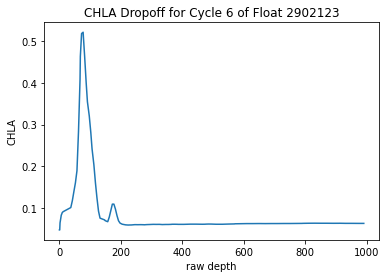

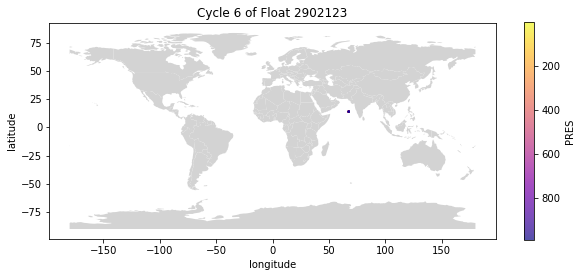

Float-cycle: 2
Number of observations in cycle: 395
Peak: 1.1419
Min: 0.0001
Euphotic floor estimate: None


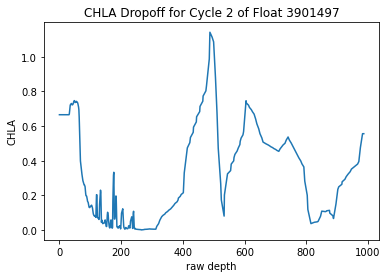

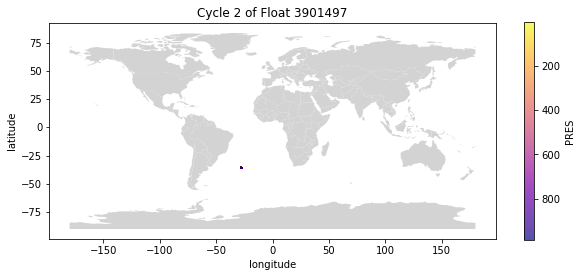

Float-cycle: 100
Number of observations in cycle: 1000
Peak: 0.0420
Min: 0.0000
Euphotic floor estimate: None


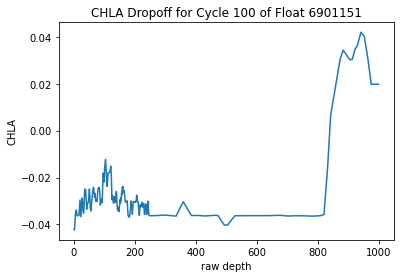

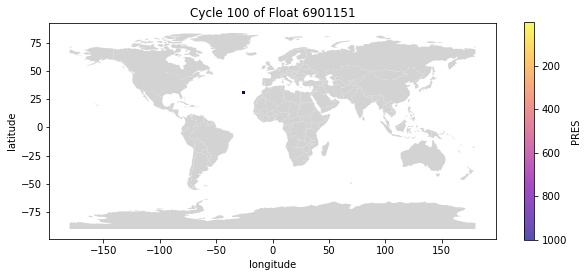

Float-cycle: 180
Number of observations in cycle: 1000
Peak: 0.1183
Min: 0.0357
Euphotic floor estimate: None


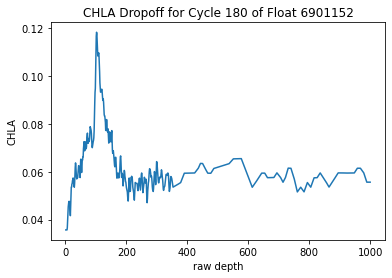

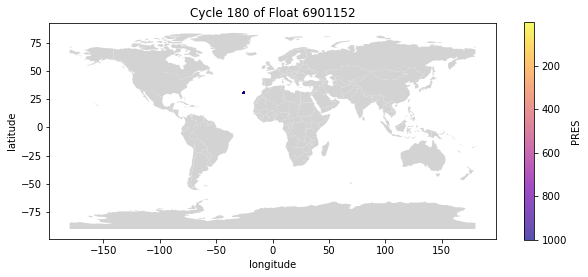

Float-cycle: 186
Number of observations in cycle: 990
Peak: 0.1179
Min: 0.0298
Euphotic floor estimate: None


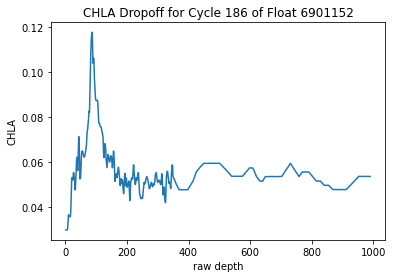

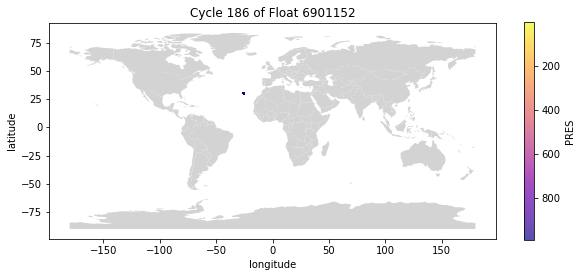

Float-cycle: 190
Number of observations in cycle: 987
Peak: 0.1387
Min: 0.0476
Euphotic floor estimate: None


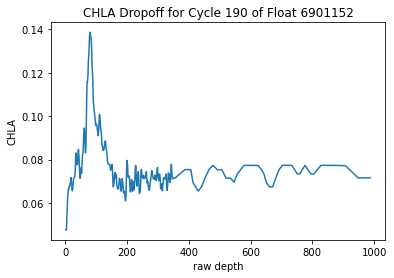

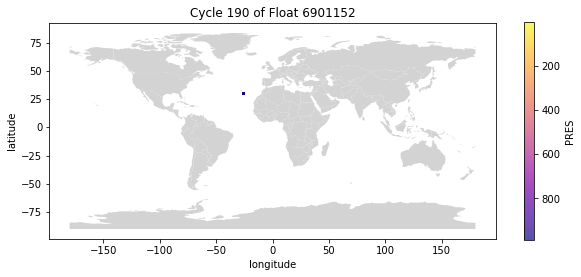

Float-cycle: 224
Number of observations in cycle: 980
Peak: 0.1527
Min: 0.1170
Euphotic floor estimate: None


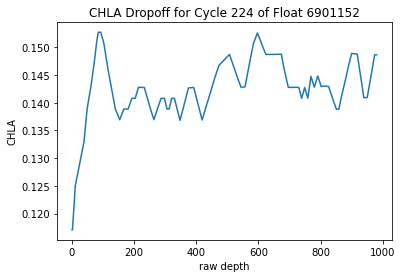

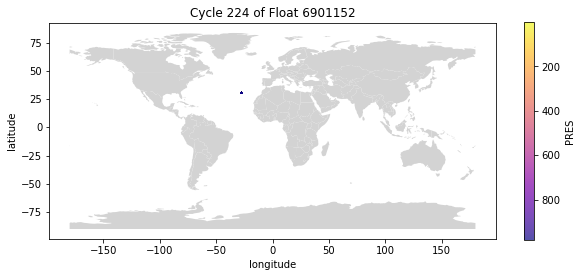

Float-cycle: 239
Number of observations in cycle: 998
Peak: 0.1666
Min: 0.0717
Euphotic floor estimate: None


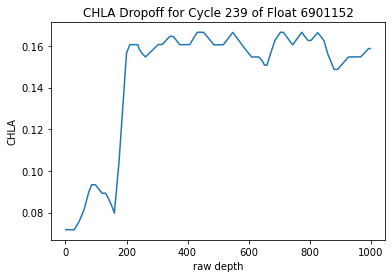

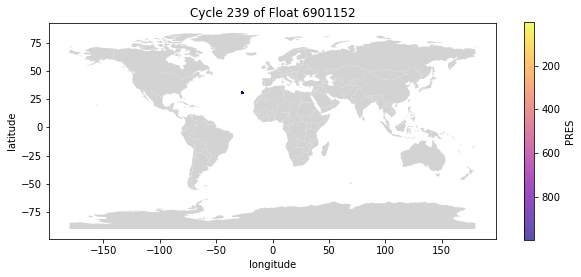

Float-cycle: 245
Number of observations in cycle: 1000
Peak: 0.0872
Min: 0.0000
Euphotic floor estimate: None


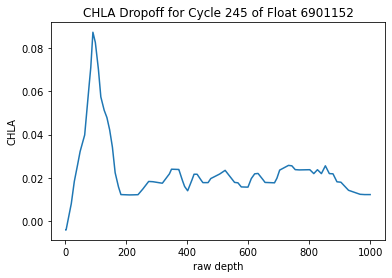

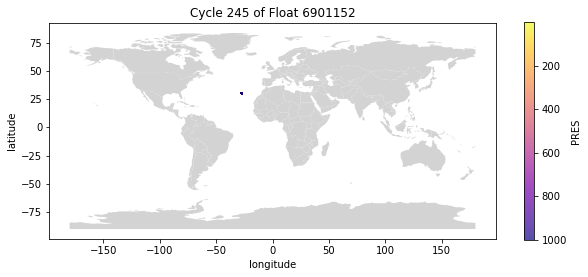

Float-cycle: 118
Number of observations in cycle: 518
Peak: 0.0377
Min: 0.0061
Euphotic floor estimate: None


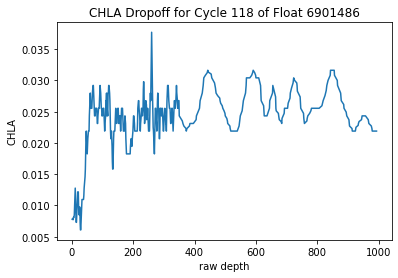

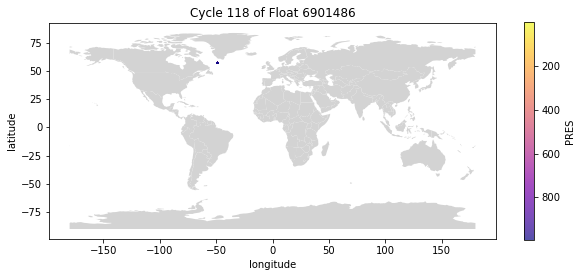

Float-cycle: 119
Number of observations in cycle: 467
Peak: 0.0328
Min: 0.0051
Euphotic floor estimate: None


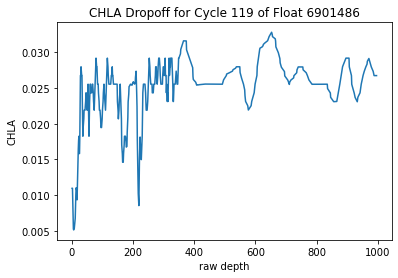

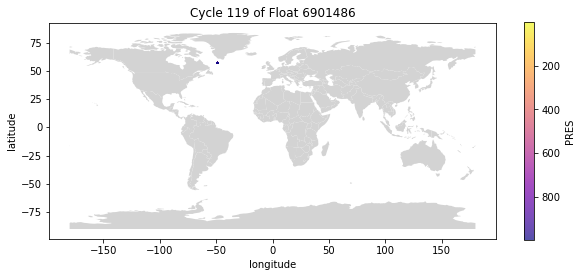

Float-cycle: 123
Number of observations in cycle: 479
Peak: 0.0584
Min: 0.0081
Euphotic floor estimate: None


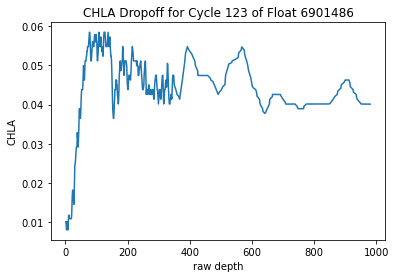

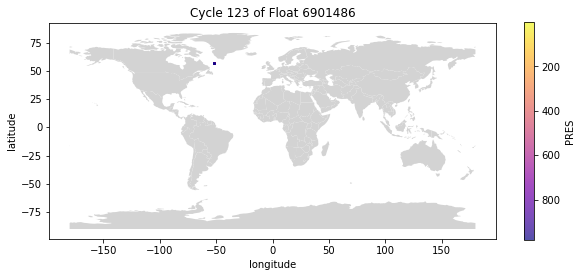

Float-cycle: 124
Number of observations in cycle: 469
Peak: 0.1362
Min: 0.0280
Euphotic floor estimate: None


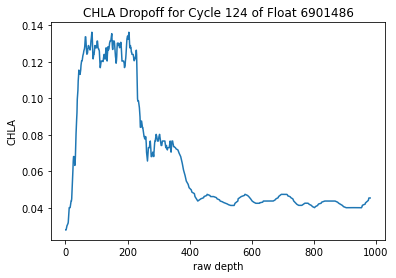

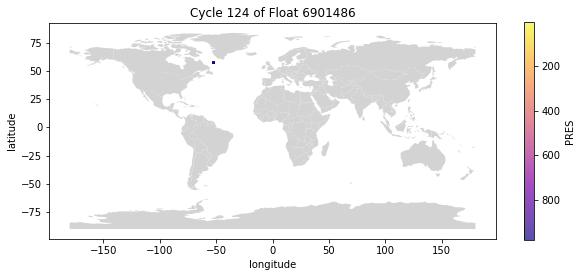

Float-cycle: 319
Number of observations in cycle: 961
Peak: 0.0517
Min: 0.0155
Euphotic floor estimate: None


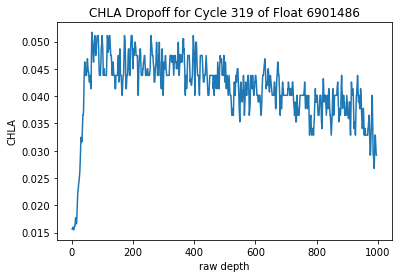

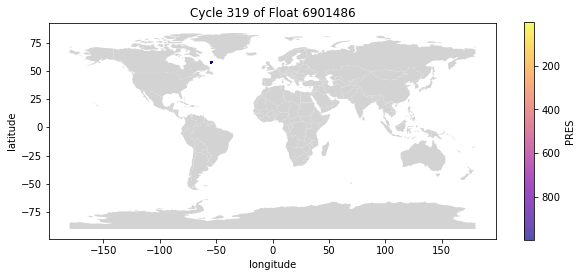

Float-cycle: 320
Number of observations in cycle: 965
Peak: 0.0596
Min: 0.0117
Euphotic floor estimate: None


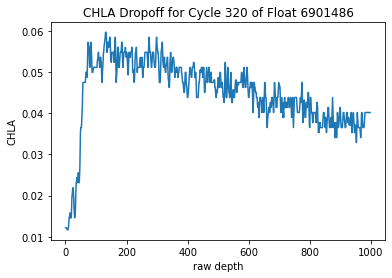

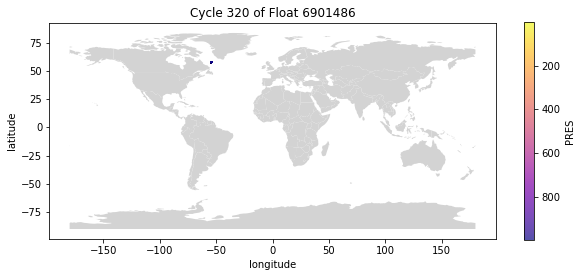

Float-cycle: 26
Number of observations in cycle: 369
Peak: 0.1202
Min: 0.0289
Euphotic floor estimate: None


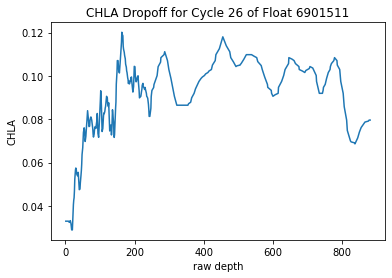

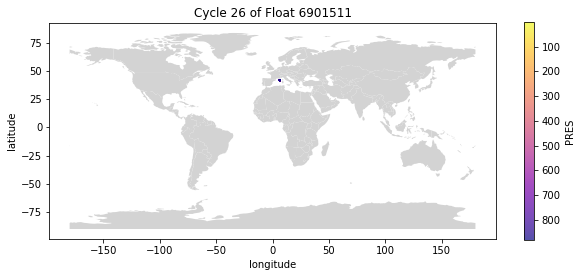

Float-cycle: 11
Number of observations in cycle: 281
Peak: 0.1971
Min: 0.0488
Euphotic floor estimate: None


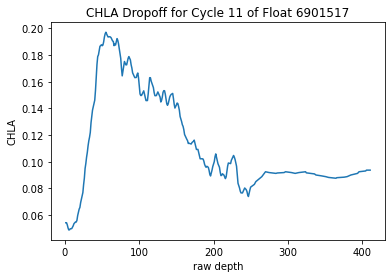

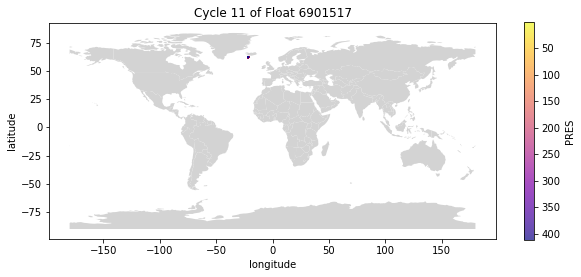

Float-cycle: 15
Number of observations in cycle: 276
Peak: 0.3135
Min: 0.0357
Euphotic floor estimate: None


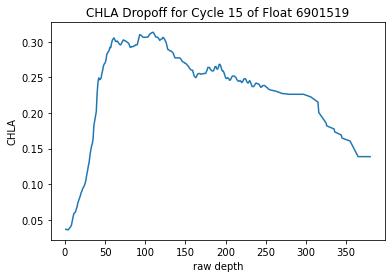

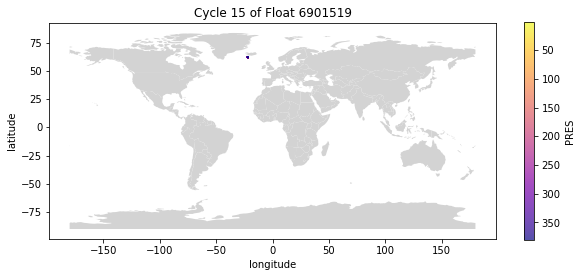

Float-cycle: 145
Number of observations in cycle: 469
Peak: 0.0684
Min: 0.0252
Euphotic floor estimate: None


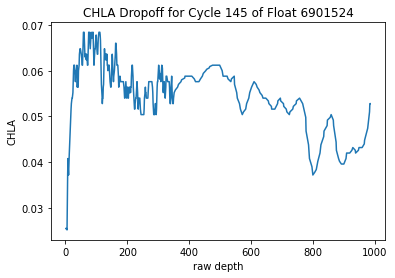

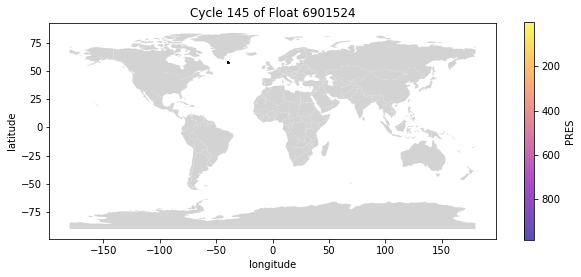

Float-cycle: 150
Number of observations in cycle: 468
Peak: 0.1080
Min: 0.0223
Euphotic floor estimate: None


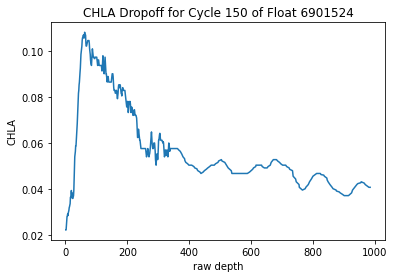

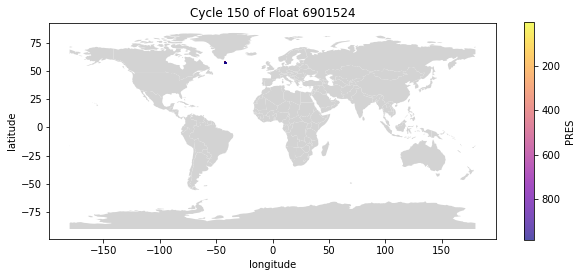

Float-cycle: 152
Number of observations in cycle: 468
Peak: 0.0612
Min: 0.0084
Euphotic floor estimate: None


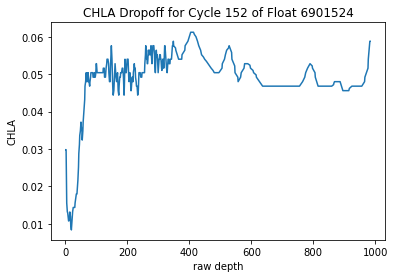

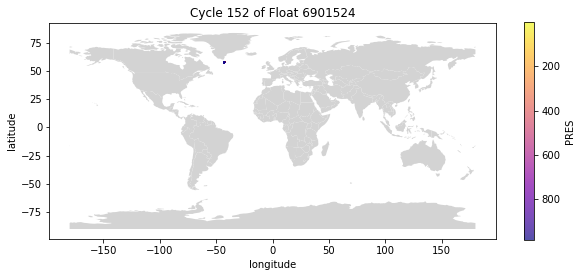

Float-cycle: 153
Number of observations in cycle: 469
Peak: 0.0804
Min: 0.0108
Euphotic floor estimate: None


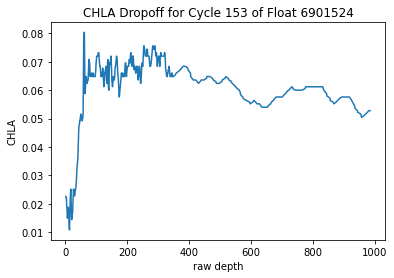

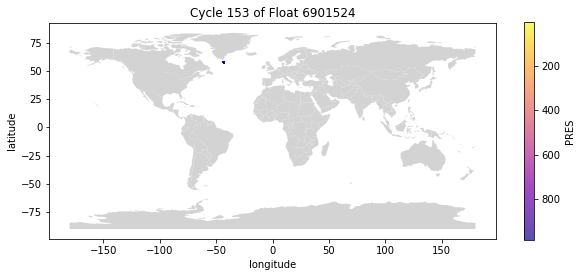

Float-cycle: 346
Number of observations in cycle: 472
Peak: 0.5340
Min: 0.0000
Euphotic floor estimate: None


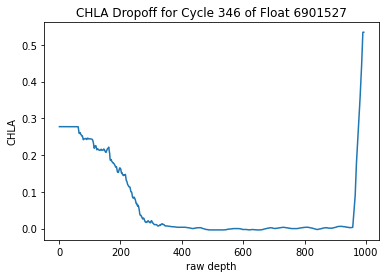

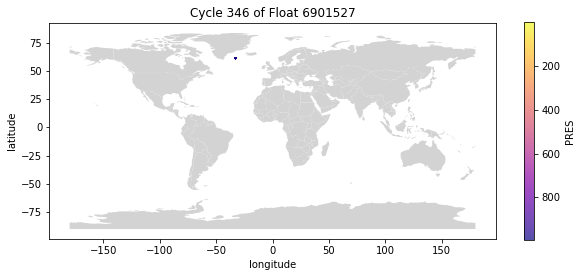

Float-cycle: 83
Number of observations in cycle: 351
Peak: 0.1471
Min: 0.0383
Euphotic floor estimate: None


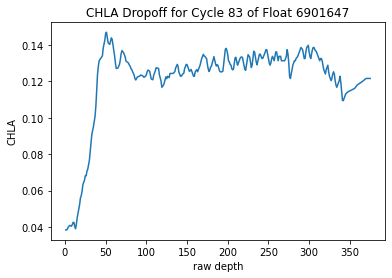

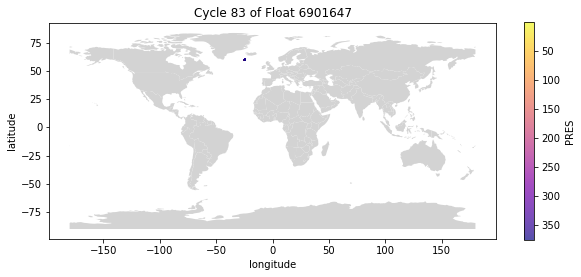

Float-cycle: 87
Number of observations in cycle: 331
Peak: 0.1509
Min: 0.0350
Euphotic floor estimate: None


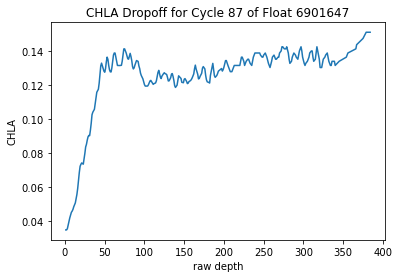

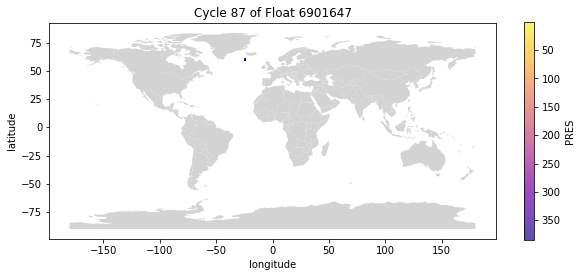

Float-cycle: 91
Number of observations in cycle: 360
Peak: 0.1678
Min: 0.0441
Euphotic floor estimate: None


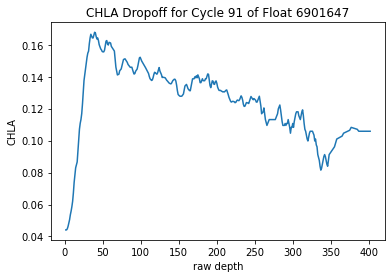

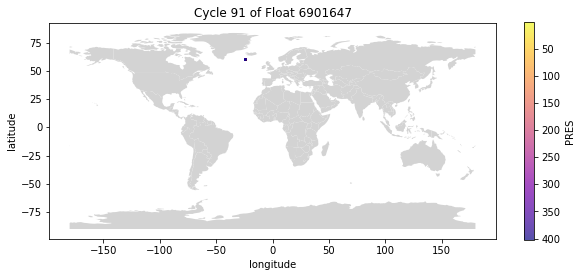

Float-cycle: 115
Number of observations in cycle: 349
Peak: 0.1674
Min: 0.0555
Euphotic floor estimate: None


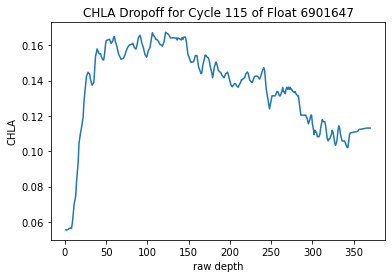

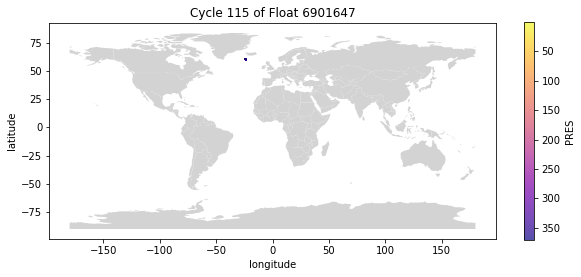

Float-cycle: 151
Number of observations in cycle: 333
Peak: 0.4294
Min: 0.0611
Euphotic floor estimate: None


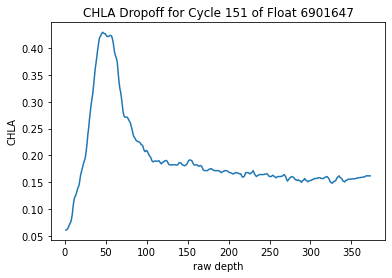

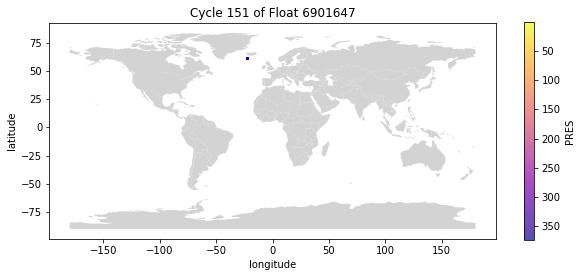

Float-cycle: 181
Number of observations in cycle: 513
Peak: 0.3857
Min: 0.0000
Euphotic floor estimate: None


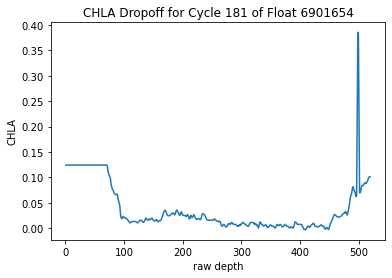

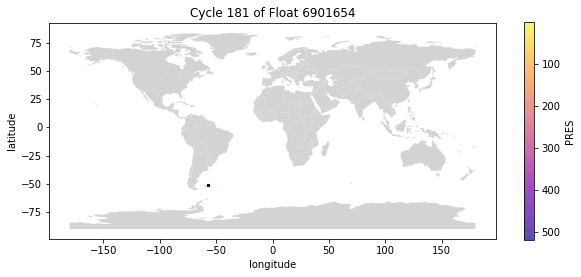

Float-cycle: 182
Number of observations in cycle: 528
Peak: 0.1776
Min: 0.0000
Euphotic floor estimate: None


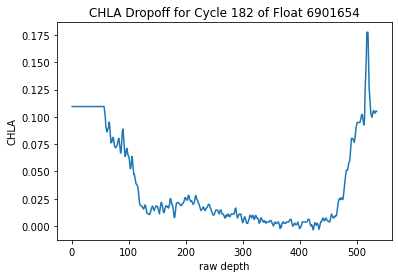

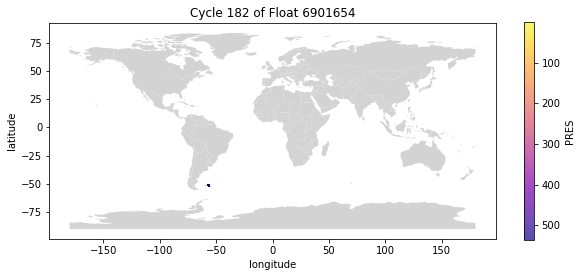

Float-cycle: 183
Number of observations in cycle: 508
Peak: 0.1734
Min: 0.0000
Euphotic floor estimate: None


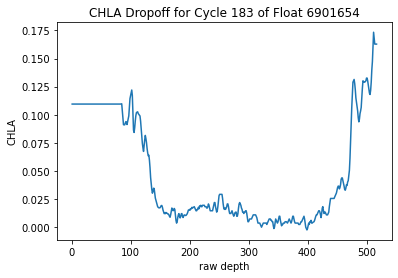

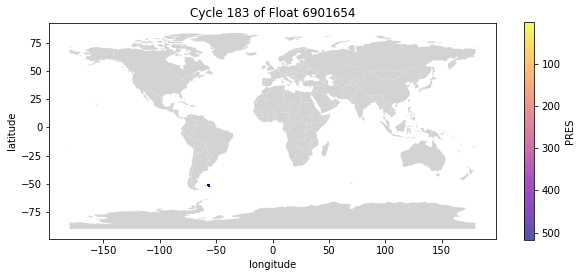

Float-cycle: 83
Number of observations in cycle: 999
Peak: 0.1835
Min: 0.0000
Euphotic floor estimate: None


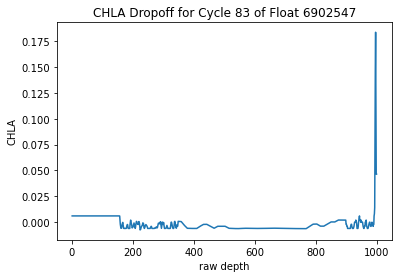

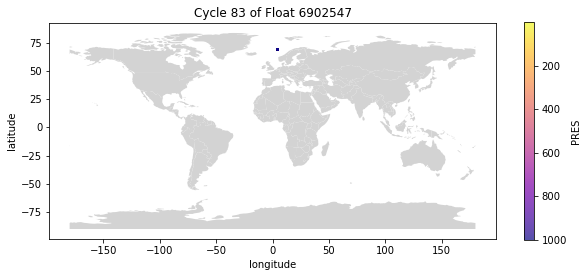

Float-cycle: 146
Number of observations in cycle: 982
Peak: 0.0141
Min: 0.0000
Euphotic floor estimate: None


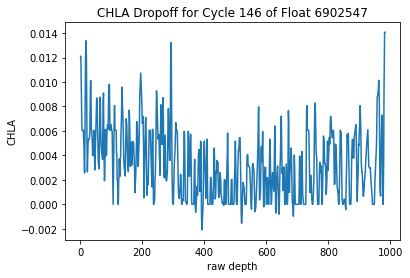

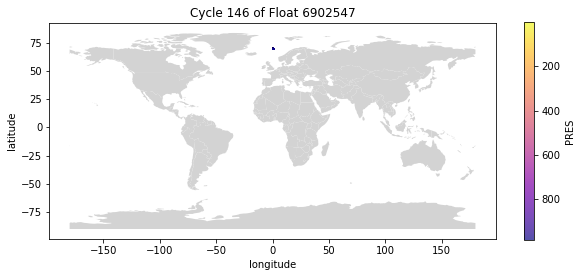

Float-cycle: 149
Number of observations in cycle: 984
Peak: 0.0121
Min: 0.0000
Euphotic floor estimate: None


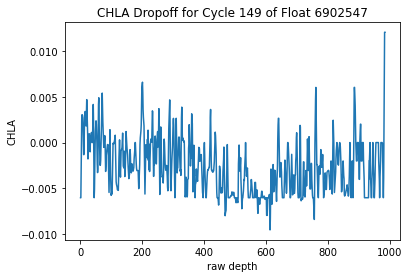

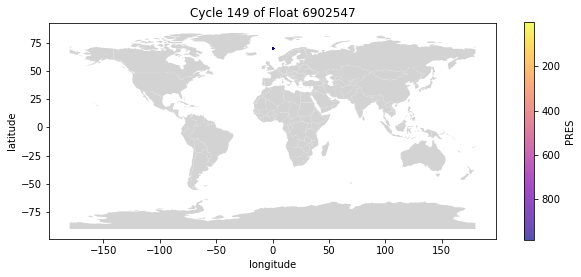

Float-cycle: 61
Number of observations in cycle: 886
Peak: 0.0897
Min: 0.0014
Euphotic floor estimate: None


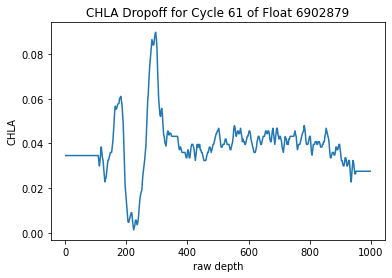

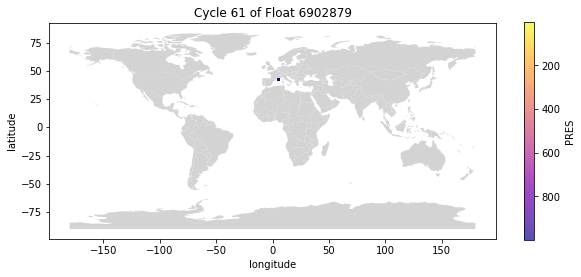

Float-cycle: 62
Number of observations in cycle: 890
Peak: 0.0624
Min: 0.0000
Euphotic floor estimate: None


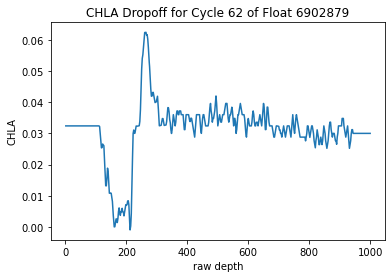

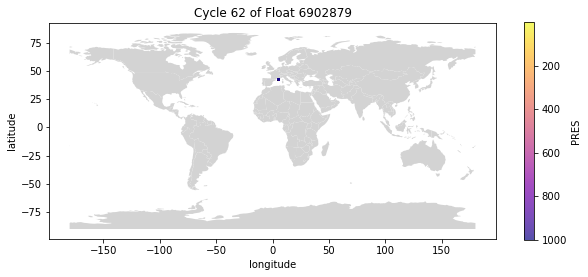

Float-cycle: 38
Number of observations in cycle: 528
Peak: 1.6973
Min: 0.0073
Euphotic floor estimate: None


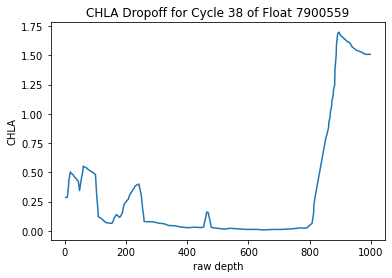

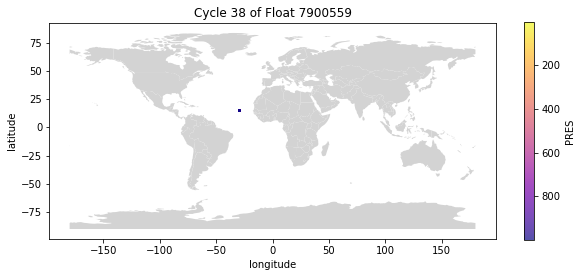

In [126]:
for f, c in estimate_not_found:
    euphotic_floor_guess = None
    float_df = df[df['float'] == f]
    cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
    max_chla = max(cycle_df['CHLA'])
    min_chla = max(0, min(cycle_df['CHLA']))
    print(f'Float-cycle: {c}')
    print(f'Number of observations in cycle: {cycle_df.shape[0]}')
    print(f'Peak: {max_chla:.4f}')
    print(f'Min: {min_chla:.4f}')

    # obtain estimate for bottom of euphotic zone depth
    chla_thresh = max(min_chla, 0.01*max_chla)

    # consider only values after the peak
    for i in range(list(cycle_df['CHLA']).index(max_chla), cycle_df.shape[0]):
        if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
            euphotic_floor_guess = cycle_df.loc[i,'PRES']
            break

    if euphotic_floor_guess is None:
        unit = ''
    else:
        unit='m'
    print(f'Euphotic floor estimate: {euphotic_floor_guess}{unit}')

    # visualize the guess; these examples should have no guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
    plot_on_map(cycle_df)



## Analyze the results

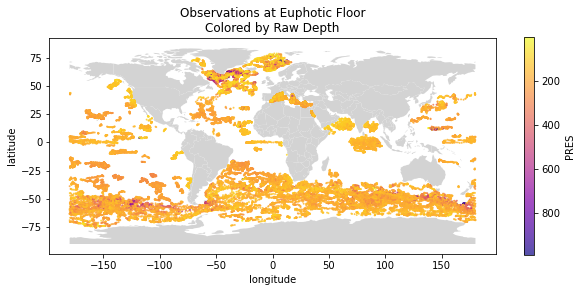

In [141]:
# display the observations colored by the depth of the euphotic floor
euphotic_floor_df = normalized_df[normalized_df['normalized_depth']==1.0].reset_index(drop=True)
plot_on_map(euphotic_floor_df, color_by='PRES', title='Observations at Euphotic Floor\nColored by Raw Depth')

# observations: most euphotic floors seem to be around 200m of raw depth


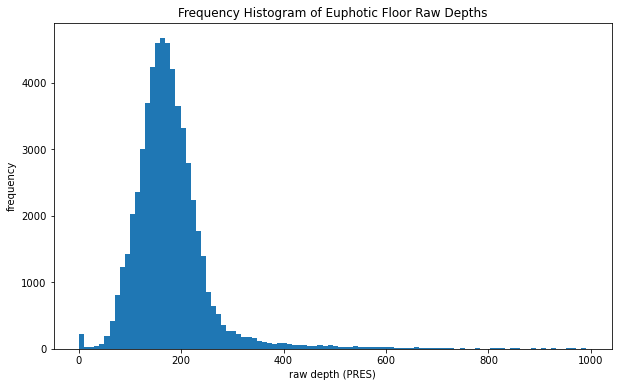

In [144]:
# display a frequency histogram of euphotic floor depths
plt.figure(figsize=(10,6))
plt.hist(euphotic_floor_df['PRES'], bins=100)
plt.title('Frequency Histogram of Euphotic Floor Raw Depths')
plt.xlabel('raw depth (PRES)')
plt.ylabel('frequency')
plt.show()


In [148]:
# analyze the cycles for which the euphotic floor is found to be below 400m or above 10m
# cycles such as these may need to be reconsidered
unusual_euphotic_floors_df = euphotic_floor_df[(euphotic_floor_df['PRES'] < 10) | (euphotic_floor_df['PRES'] > 400)].reset_index(drop=True)
unusual_euphotic_floors_df.shape


(1364, 15)

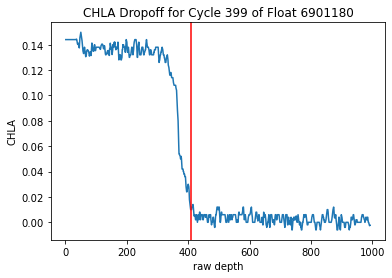

In [156]:
unusual_float_cycles = [(unusual_euphotic_floors_df.loc[i,'float'], unusual_euphotic_floors_df.loc[i,'cycleNumber']) for i in range(unusual_euphotic_floors_df.shape[0])]
f, c = random.choice(unusual_float_cycles)
float_df = df[df['float'] == f]
cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
euphotic_floor_guess = unusual_euphotic_floors_df[(unusual_euphotic_floors_df['float'] == f) & (unusual_euphotic_floors_df['cycleNumber'] == c)].reset_index(drop=True).loc[0,'PRES']
plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)


## Finalize and save the dataframe

In [129]:
# add a column for the day of the year in radians
normalized_df.insert(loc=list(normalized_df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in normalized_df['date']])

# ensure the rows of the dataframe are unique
assert(normalized_df.shape[0] == normalized_df.drop_duplicates().shape[0])

normalized_df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225384,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
8225385,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
8225386,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
8225387,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [134]:
# save the dataframe
# note that the 37 ambiguous cycles are NOT included in the results;
# further investigation is required into these examples before estimating the euphotic floor
result_file = 'float_sat_normalized_depth.csv'
normalized_df.to_csv(path + result_file, index=False)
